In [ ]:
import sys
import os 
sys.path.append(os.path.dirname(os.getcwd()) + "/src/")

import numpy as np
import torch
import omegaconf

from eval.utils import encode_features
from model.model import Model
from model.config import ModelConfig
from dataloader.ssl_dataloader import get_dataset
from matplotlib import pyplot as plt
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import sparse
from scipy.linalg import circulant
import warnings
warnings.filterwarnings("ignore")
import copy

from sklearn import cluster
from sklearn.preprocessing import normalize


/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Boilerplate needed for notebooks

In [5]:

# ckpt_path = "../results/working_models/simclr_cifar10_vi100s-nn_dict100.pt"
# cfg_path = "../results/working_models/cfg_simclr_cifar10_vi100s-nn_dict100.yaml"
ckpt_path = "../results/prioraug_vi100-nn_dict64_prior-grad_shift1e-3_ntx1e-1_lie1e-1_l0.005_prior-warmup_04-08-2023_11-52-26/checkpoints/checkpoint_epoch999.pt"
cfg_path = "../results/prioraug_vi100-nn_dict64_prior-grad_shift1e-3_ntx1e-1_lie1e-1_l0.005_prior-warmup_04-08-2023_11-52-26/.hydra/config.yaml"


device_idx = [0, 1]
# Set the default device
default_device = torch.device("cuda:0")
# Load config
cfg = omegaconf.OmegaConf.load(cfg_path)
cfg.model_cfg.backbone_cfg.load_backbone = None

# CUSTOM CONFIG FOR THIS RUN #

# Load model
default_model_cfg = ModelConfig()
model = Model.initialize_model(cfg.model_cfg, cfg.dataloader_cfg.dataset_cfg.dataset_name, device_idx)
state_dict = torch.load(ckpt_path, map_location=default_device)
model.load_state_dict(state_dict['model_state'], strict=False)
# Manually override directory for dataloaders
cfg.dataloader_cfg.dataset_cfg.dataset_dir = "../datasets"
cfg.dataloader_cfg.train_batch_size = 500
# Load dataloaders
dataset = get_dataset(cfg.dataloader_cfg)
train_dataloader = dataset.eval_dataloader
test_dataloader = dataset.val_dataloader
# Get encoding of entire dataset
train_eval_input = encode_features(model, train_dataloader, default_device)
test_eval_input = encode_features(model, test_dataloader, default_device)

# Load transport operators
psi = model.module.contrastive_header.transop_header.transop.get_psi()
transop = model.module.contrastive_header.transop_header.transop
coeff_enc = model.module.contrastive_header.transop_header.coefficient_encoder

Using cache found in /home/kion/.cache/torch/hub/pytorch_vision_v0.10.0


Files already downloaded and verified
Files already downloaded and verified


In [6]:
x, z, y = train_eval_input.x, train_eval_input.feature_list, train_eval_input.labels
x_test, z_test, y_test = test_eval_input.x, test_eval_input.feature_list, test_eval_input.labels

train_labels_per_class = 10
x_subset = []
z_subset = []
y_subset = []
for i in range(10):
    label_idx = np.where(y == i)[0]
    subset = np.random.choice(label_idx, train_labels_per_class, replace=False)
    x_subset.append(x[subset])
    z_subset.append(z[subset])
    y_subset.append(y[subset])
x_subset = torch.cat(x_subset)
z_subset = torch.cat(z_subset)
y_subset = torch.cat(y_subset)

test_labels_per_class = 50
x_test_subset = []
z_test_subset = []
y_test_subset = []
for i in range(10):
    label_idx = np.where(y_test == i)[0]
    subset = np.random.choice(label_idx, test_labels_per_class, replace=False)
    x_test_subset.append(x_test[subset])
    z_test_subset.append(z_test[subset])
    y_test_subset.append(y_test[subset])
x_test_subset = torch.cat(x_test_subset)
z_test_subset = torch.cat(z_test_subset)
y_test_subsetbset = torch.cat(y_test_subset)

In [33]:
from model.manifold.reparameterize import compute_kl

def spectral_cluster(W_affinity, k):
    laplacian = sparse.csgraph.laplacian(W_affinity, normed=True)
    _, vec = sparse.linalg.eigsh(sparse.identity(laplacian.shape[0]) - laplacian, k=k, sigma=None, which='LA')
    embedding = normalize(vec)
    _, labels_, _ = cluster.k_means(embedding, k,  random_state=0, n_init=100)
    return labels_

def purity_accuracy(X, y_true, y_pred, num_clusters=10):
    acc = 0
    for i in range(num_clusters):
        purity_label = sp.stats.mode(y_true[y_pred == i])[0]
        correct_labels = (purity_label == y_true[y_pred == i])
        acc += correct_labels.sum()
    acc = 100 * (acc / len(X))
    return acc

z_subset = z_subset.to(default_device)
transop = model.contrastive_header.transop_header.transop

if cfg.model_cfg.header_cfg.transop_header_cfg.enable_block_diagonal:
    block_dim = cfg.model_cfg.header_cfg.transop_header_cfg.block_dim
    z_subset = z_subset.reshape(-1, 512 // block_dim, block_dim)

coeff_enc.vi_cfg.total_num_samples = 100
coeff_enc.vi_cfg.samples_per_iter = 50

coeff_enc.lambda_prior = 0.04
coeff_enc.thresh_warmup = 1.0
coeff_enc.vi_cfg.max_sample_l1_penalty = 1.0e-3

num_samples = 100
circ_idx = circulant(np.arange(num_samples))
pairwise_loss = torch.zeros(len(z_subset), len(z_subset))
pairwise_kl_loss = torch.zeros(len(z_subset), len(z_subset))
pairwise_coeff = torch.zeros(len(z_subset), len(z_subset), 8, len(psi))
c_list = []

for p in range(0, len(z_subset) // num_samples):
    z0_idx = np.arange(len(z_subset))[p*num_samples:(p+1)*num_samples]
    z0 = z_subset[z0_idx]
    for k in range(0, len(z_subset) // num_samples):
        z1_idx = np.arange(len(z_subset))[k*num_samples:(k+1)*num_samples]
        for circ in circ_idx:
            z1 = z_subset[z1_idx[circ]]

            distribution_data = coeff_enc(z0, z1, transop, 50000)
            c = distribution_data.samples
            c_list.append(c.detach().cpu())
            #c = refine_coeff(c, z0, z1, psi, 0.5, iters=50)
            
            T = torch.matrix_exp(torch.einsum('bsm,mpk->bspk', c, psi))
            z1_hat = (T @ z0.unsqueeze(-1)).squeeze(-1)
            transop_loss = ((z1_hat - z1)**2).sum(dim=(-1, -2))

            kl_loss = compute_kl(
                coeff_enc.vi_cfg.distribution,
                distribution_data.encoder_params,
                distribution_data.prior_params
            )

            pairwise_loss[(z0_idx, z1_idx[circ])] = transop_loss.detach().cpu()
            pairwise_kl_loss[(z0_idx, z1_idx[circ])] = kl_loss.sum(-1).detach().cpu()
            pairwise_coeff[(z0_idx, z1_idx[circ])] = c.detach().cpu()

c_list = torch.cat(c_list)
print(f"Avg NZ : {torch.count_nonzero(c_list, dim=-1).float().mean()}")
c_mag = [c[c.abs() > 0].abs().mean().item() for c in c_list.reshape(-1, 40).T]
print(f"Avg c mag : {c_mag}")

Avg NZ : 7.581699848175049
Avg c mag : [0.10936906188726425, 0.09495135396718979, 0.09613027423620224, 0.0906371995806694, 0.09780778735876083, 0.12463057786226273, 0.10113675147294998, 0.1165967583656311, 0.11091573536396027, 0.09612368792295456, 0.09860861301422119, 0.09920971095561981, 0.09158997982740402, 0.10245604068040848, 0.09607815742492676, 0.12707607448101044, 0.10095352679491043, 0.10490351915359497, 0.09977061301469803, 0.09821190685033798, 0.11004514247179031, 0.10223685950040817, 0.09414485096931458, 0.09928058087825775, 0.0887388288974762, 0.12975051999092102, 0.10048486292362213, 0.11667598783969879, 0.11542867124080658, 0.10266367346048355, 0.09762553125619888, 0.1061730682849884, 0.09240782260894775, 0.10361672937870026, 0.09309562295675278, 0.12936995923519135, 0.10315153747797012, 0.11939240247011185, 0.10142657905817032, 0.08926036953926086]


65.0
66.94736509978561
44.059829059829056

65.0
65.31711733752525
41.26382306477093


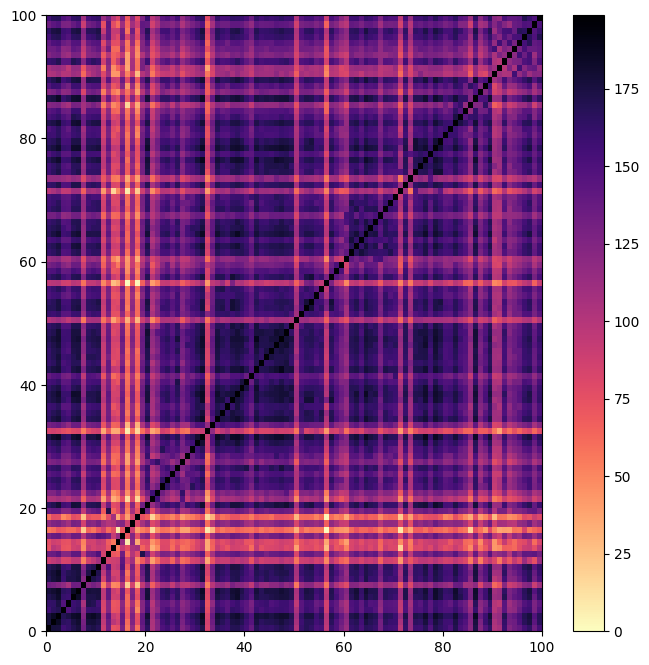

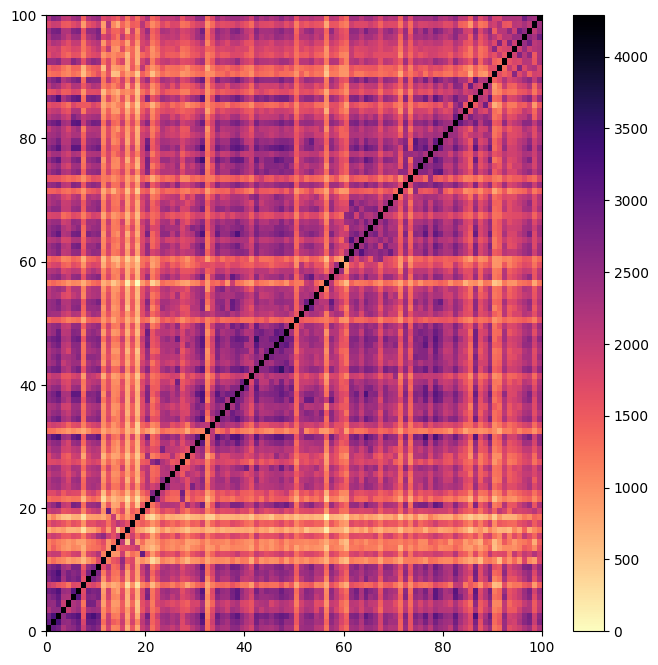

In [35]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
simmilarity_mtx = pairwise_loss.numpy()
simmilarity_mtx = 0.5 * (np.abs(simmilarity_mtx) + np.abs(simmilarity_mtx).T)
simmilarity_mtx = np.max(simmilarity_mtx) - simmilarity_mtx
plt.figure(figsize=(8,8))
plt.pcolormesh(simmilarity_mtx, cmap='magma_r')
plt.colorbar()

pred_labels = spectral_cluster(simmilarity_mtx, 10)
acc_recon = purity_accuracy(z_subset, y_subset.numpy(), pred_labels, num_clusters=10)
nmi = normalized_mutual_info_score(y_subset, pred_labels)
ari = adjusted_rand_score(y_subset, pred_labels)
print(acc_recon)
print(nmi * 100)
print(ari * 100)
print()

beta = 1.0e0
simmilarity_mtx = pairwise_loss.numpy() + beta * pairwise_kl_loss.numpy()
simmilarity_mtx = 0.5 * (np.abs(simmilarity_mtx) + np.abs(simmilarity_mtx).T)
simmilarity_mtx = np.max(simmilarity_mtx) - simmilarity_mtx
plt.figure(figsize=(8,8))
plt.pcolormesh(simmilarity_mtx, cmap='magma_r')
plt.colorbar()

pred_labels = spectral_cluster(simmilarity_mtx, 10)
acc_recon = purity_accuracy(z_subset, y_subset.numpy(), pred_labels, num_clusters=10)
nmi = normalized_mutual_info_score(y_subset, pred_labels)
ari = adjusted_rand_score(y_subset, pred_labels)
print(acc_recon)
print(nmi * 100)
print(ari * 100)

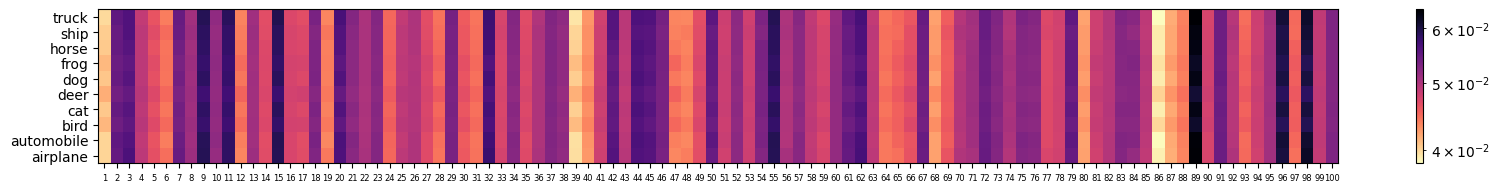

In [22]:
from sklearn.manifold import Isomap
import matplotlib
embedding = Isomap(n_components=2)
X = embedding.fit_transform(z_subset)
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# plt.figure()
# for i in range(10):
#     label_idx = np.where(y_subset == i)[0]
#     plt.scatter(*X[label_idx].T, marker=f'${i}$')

prior_params = coeff_enc.get_prior_params(z.to(default_device))[0]
scale = prior_params["logscale"].exp().detach().cpu()

psi_check = [2, 3, 4, 12, 21, 37, 35, 36, 39]
# for k in range(8):
#     plt.figure()
#     for i in range(10):
#         label_idx = np.where(y_subset == i)[0]
#         c = scale[label_idx, :, k].mean(dim=1) * 10
#         plt.scatter(*X[label_idx].T, marker=f'${i}$', c=c)
#     plt.colorbar()
scale_per_class = np.zeros((10, 100))
for i in range(10):
    idx = y == i
    scale_per_class[i] = scale[idx].mean(dim=0)

plt.figure(figsize=(20, 2))
plt.pcolormesh(scale_per_class, cmap='magma_r', norm=matplotlib.colors.LogNorm())
plt.yticks(np.arange(10)+0.5, cifar10_labels)
plt.xticks(np.arange(100)+0.5, np.arange(100) + 1, fontsize=6)
plt.colorbar()



Avg NZ : 5.391432285308838



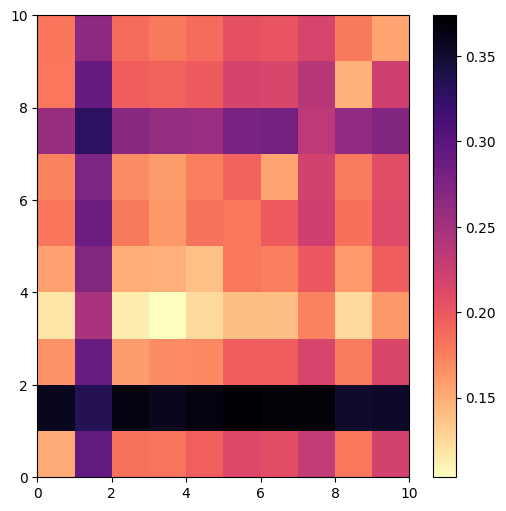

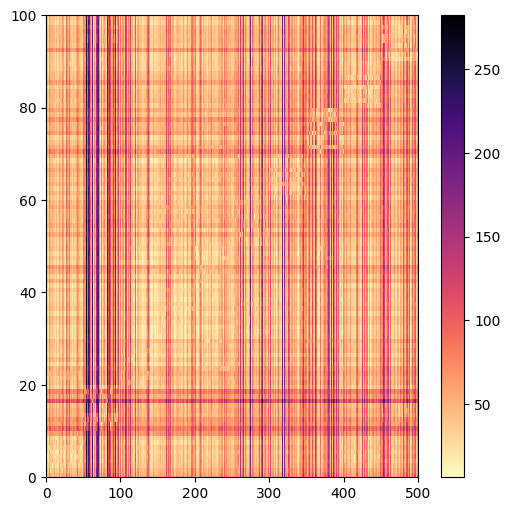

In [86]:
euc_pairwise_dist = ((z_subset.unsqueeze(1) - z_test_subset.unsqueeze(0))**2).mean(-1)
euc_class_avg_dist = euc_pairwise_dist.reshape(10, train_labels_per_class, 10, test_labels_per_class).mean(dim=(1,3))
plt.figure(figsize=(6, 6))
plt.pcolormesh(euc_class_avg_dist, cmap='magma_r')
plt.colorbar()
print()

if cfg.model_cfg.header_cfg.transop_header_cfg.enable_block_diagonal:
    block_dim = cfg.model_cfg.header_cfg.transop_header_cfg.block_dim
    z_train_block = z_subset.reshape(-1, 512 // block_dim, block_dim).to(default_device)
    z_test_block = z_test_subset.reshape(-1, 512 // block_dim, block_dim).to(default_device)

coeff_enc.vi_cfg.total_num_samples = 100
coeff_enc.vi_cfg.samples_per_iter = 100

coeff_enc.lambda_prior = 0.05
coeff_enc.thresh_warmup = 1.0
coeff_enc.vi_cfg.max_sample_l1_penalty = 1.0e-3

num_samples = 50
circ_idx = circulant(np.arange(num_samples))
pairwise_dist = torch.zeros(len(z_train_block), len(z_test_block))
pairwise_coeff = torch.zeros(len(z_train_block), len(z_test_block), 8, len(psi))
c_list = []

z0 = z_train_block
for p in range(0, len(z_train_block) // num_samples):
    z0_idx = np.arange(len(z_train_block))[p*num_samples:(p+1)*num_samples]
    z0 = z_train_block[z0_idx]
    for k in range(0, len(z_test_block) // num_samples):
        z1_idx = np.arange(len(z_test_block))[k*num_samples:(k+1)*num_samples]
        for circ in circ_idx:
            z1 = z_test_block[z1_idx[circ]]

            distribution_data = coeff_enc(z0, z1, transop, 50000)
            c = distribution_data.samples
            c_list.append(c.detach().cpu())
            #c = refine_coeff(c, z0, z1, psi, 0.5, iters=50)
            
            T = torch.matrix_exp(torch.einsum('bsm,mpk->bspk', c, psi))
            z1_hat = (T @ z0.unsqueeze(-1)).squeeze(-1)
            transop_loss = ((z1_hat - z1)**2).sum(dim=(-1, -2))

            pairwise_dist[(z0_idx, z1_idx[circ])] = transop_loss.detach().cpu()
            pairwise_coeff[(z0_idx, z1_idx[circ])] = c.detach().cpu()

c_list = torch.cat(c_list)
print(f"Avg NZ : {torch.count_nonzero(c_list, dim=-1).float().mean()}")

#class_avg_dist = pairwise_dist.reshape(10, train_labels_per_class, -1).mean(dim=1)
class_avg_dist = pairwise_dist.reshape(10, class_avg_dist, 10, test_labels_per_class).mean(dim=(1,3))
plt.figure(figsize=(6, 6))
plt.pcolormesh(pairwise_dist, cmap='magma_r')
plt.colorbar()
print()


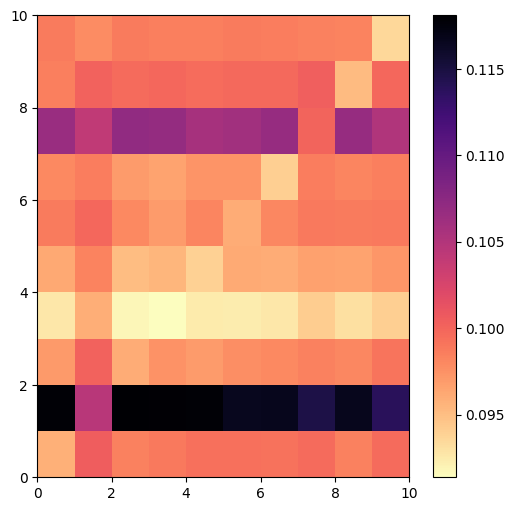

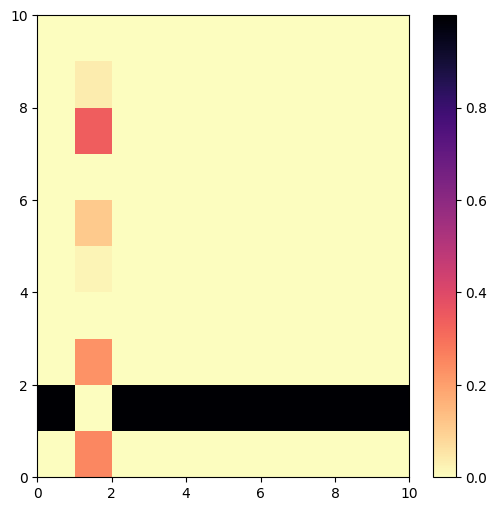

In [91]:
euc_pairwise_dist = ((z_subset.unsqueeze(1) - z_test_subset.unsqueeze(0))**2).mean(-1)
euc_class_avg_dist = euc_pairwise_dist.reshape(10, train_labels_per_class, 10, test_labels_per_class).mean(dim=(1,3))
plt.figure(figsize=(6, 6))
plt.pcolormesh(torch.softmax(euc_class_avg_dist, dim=0), cmap='magma_r')
plt.colorbar()

class_avg_dist = pairwise_dist.reshape(10, train_labels_per_class, 10, test_labels_per_class).mean(dim=(1,3))
plt.figure(figsize=(6, 6))
plt.pcolormesh(torch.softmax(class_avg_dist, dim=0), cmap='magma_r')
plt.colorbar()


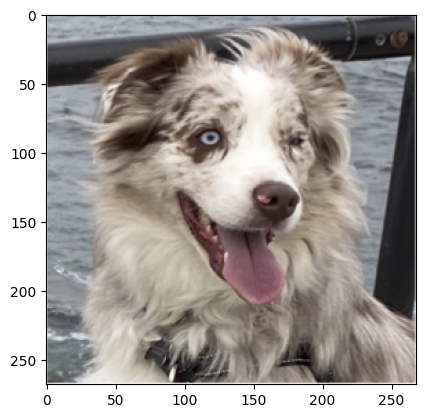

In [3]:
import PIL.Image
import torchvision.transforms as T
from matplotlib import pyplot as plt
%matplotlib inline
image = PIL.Image.open(r'umes.png')
plt.figure()
plt.imshow(image)

T.Compose(
        [
            T.RandomApply(
                [T.ColorJitter(cfg.cj_bright, cfg.cj_contrast, cfg.cj_sat, cfg.cj_hue)], p=cfg.cj_prob
            ),
            T.RandomGrayscale(p=cfg.gray_scale),
            T.RandomResizedCrop(
                268,
                scale=(cfg.min_scale, 1.0),
                ratio=(0.75, (4 / 3)),
                interpolation=3,
            )
        ]
    )